## Введение. Цель анализа

### Описание бизнеса:
<p>Интернет-магазин товаров для дома «Пока все ещё тут».</p>

### Цель анализа:
<p> Сегментировать покупателей по профилю потребления.

### Задачи:
* Сегментировать клиентов по категорям приобретаемых товаров:
  * выделить основные категории товаров
  * агрегировать данные относительно категорий
* Провести исследовательский анализ на выявления общих признаков, характерных для каждой категории: 
  * средний чек 
  * количество клиентов 
  * среднее количество покупок на одного клиента 
  * самые популярные категории (товары) 
  * посмотреть на распределение данных о транзациях по дате совершения покупки
*Результаты по категориям необходимы заказчику для создания персонализированных предложений для покупателей (таргетинг). Эта информация позволит заказчику найти ответы на вопросы: какие товары стоит рекомендовать покупателю в определенный момент времени? В какое время стоит показывать рекламу ? Какие категории товаров следует обновить, дополнить для увеличения спроса и конверсии ?*
* На основе ML алгоритмов кластеризации выделить основные сегменты пользователей
  * Посмотреть какие признаки характерны для каждой группы (категории товаров, средний чек и т.д).   
  * Выделить сегмент, который приносит наибольшую прибыль.
  * Проверить статистические показатели для разных сегментов, чтобы подвердить различие наблюдаемых групп.

## Загрузка данных. Первый взгляд.

В рамках этого раздела проведем загрузку необходимых для работы библиотек, также загрузим исходные данные и посмотрим на их структуру, объем и наличие пропусков и дубликатов.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
pd.options.display.float_format ='{:,.2f}'.format
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from io import BytesIO
import requests

https://docs.google.com/spreadsheets/d/1IAJgAJVGOQMZV_Z2atuh39AR9IZlLCZamUVOTJhPW-g/edit?usp=sharing

Загрузим в датафрейм исходные данные.

In [ ]:
spreadsheet_id = '1IAJgAJVGOQMZV_Z2atuh39AR9IZlLCZamUVOTJhPW-g'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
data = pd.read_csv(BytesIO(r.content))

In [ ]:
data.head()

,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.00
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.00
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.00
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.00
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.00


Названия столбцов корректны. Столбец date нужно будет перевести в тип данных datetime. Также можно заметить, что записи 'customer_id' и 'order_id' не являются уникальными, т.к заказ разбивается по каждому продукту в заказе. Посмотрим на сводную информацию по датасету.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         6737 non-null   int64  
 1   customer_id  6737 non-null   object 
 2   order_id     6737 non-null   int64  
 3   product      6737 non-null   object 
 4   quantity     6737 non-null   int64  
 5   price        6737 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 315.9+ KB


Всего в таблице 6737 строк. Пропусков в столбцах не обнаружено. Все столбцы имееют необходимые типы данных, кроме date.

Посмотрим на наличие дубликатов.

In [ ]:
data.duplicated().sum()

0

## Предобработка данных

В данном разделе произведем необходимые изменения с данными. Изменим тип данных столбца date.

In [ ]:
data['date'] = pd.to_datetime(data['date'], format = '%Y%m%d%H')

In [ ]:
data['date'].tail()

6732   2019-10-31 11:00:00
6733   2019-10-31 12:00:00
6734   2019-10-31 13:00:00
6735   2019-10-31 14:00:00
6736   2019-10-31 16:00:00
Name: date, dtype: datetime64[ns]

Выделим из даты год, месяц, день и час совершения заказа.

In [ ]:
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['week_day'] = data['date'].dt.weekday
data['day'] = data['date'].dt.date.astype('datetime64')
data['hour'] = data['date'].dt.hour

In [ ]:
data.tail()

,date,customer_id,order_id,product,quantity,price,year,month,week_day,day,hour
6732,2019-10-31 11:00:00,73d1cd35-5e5f-4629-8cf2-3fda829d4e58,73156,"Таз пластмассовый 40,0 л пищевой овальный (Иж)...",1,404.00,2019,10,3,2019-10-31,11
6733,2019-10-31 12:00:00,1f0a7f35-7459-4f23-b468-5e45bf481dd1,73158,Сумка-тележка 2-х колесная Gimi Argo синяя,1,"1,087.00",2019,10,3,2019-10-31,12
6734,2019-10-31 13:00:00,25df96a7-c453-4708-9cea-a3dfc7c342ea,73162,Герань домашняя (пеларгония зональная) цветуща...,1,157.00,2019,10,3,2019-10-31,13
6735,2019-10-31 14:00:00,73d1cd35-5e5f-4629-8cf2-3fda829d4e58,73164,"Таз пластмассовый со стиральной доской (Иж), 1...",1,397.00,2019,10,3,2019-10-31,14
6736,2019-10-31 16:00:00,344aa778-e436-419e-a9c6-9b8f37b7c1df,73137,Сумка-тележка 2-х колесная Gimi Argo синяя,1,"1,087.00",2019,10,3,2019-10-31,16


Поменяем на нижний регистр названия товаров.

In [ ]:
data['product'] = data['product'].str.lower()

## Исследовательский анализ данных

В данном разделе необходимо посмотреть на распределения данных и выявить аномалии. Провести агрегирование товаров по категориям и посмотреть на срений чек, количество покупателей и т.д

Сначала посчитаем общую сумму по заказу, умножив количество товара на его стоимость. Добавим столбец "sum_total".

In [ ]:
data['sum_total'] = data['quantity'] * data['price']

Определим период за который предоставлены данные.

In [ ]:
print('Данные по заказам с {} по {}'.format(data['date'].min(), data['date'].max()))

Данные по заказам с 2018-10-01 00:00:00 по 2019-10-31 16:00:00


Посмотрим как менялась по месяцам выручка и количество заказов интернет-магазина.

In [ ]:
revenue = data.groupby(['year', 'month'], as_index=False)\
.agg({'sum_total': ['sum', 'mean'], 'order_id': 'nunique'})\
.droplevel(level=1, axis=1)\
.rename(columns={'sum_total': 'total_revenue', 'order_id': 'amount_orders'})
revenue

,year,month,total_revenue,total_revenue,amount_orders
0,2018,10,"420,754.00",742.07,239
1,2018,11,"371,180.00",783.08,205
2,2018,12,"402,768.00","1,057.13",286
3,2019,1,"284,721.00","1,259.83",171
4,2019,2,"345,454.00",809.03,290
5,2019,3,"320,018.00",637.49,250
6,2019,4,"381,915.00",497.93,269
7,2019,5,"306,744.00",353.39,186
8,2019,6,"1,086,681.00",778.42,166
9,2019,7,"276,547.00",691.37,199


In [ ]:
col_names = revenue.columns.values
col_names[3] = 'purchase_mean'
revenue.columns = col_names
revenue

,year,month,total_revenue,purchase_mean,amount_orders
0,2018,10,"420,754.00",742.07,239
1,2018,11,"371,180.00",783.08,205
2,2018,12,"402,768.00","1,057.13",286
3,2019,1,"284,721.00","1,259.83",171
4,2019,2,"345,454.00",809.03,290
5,2019,3,"320,018.00",637.49,250
6,2019,4,"381,915.00",497.93,269
7,2019,5,"306,744.00",353.39,186
8,2019,6,"1,086,681.00",778.42,166
9,2019,7,"276,547.00",691.37,199


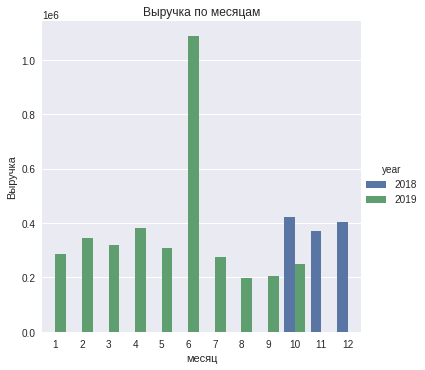

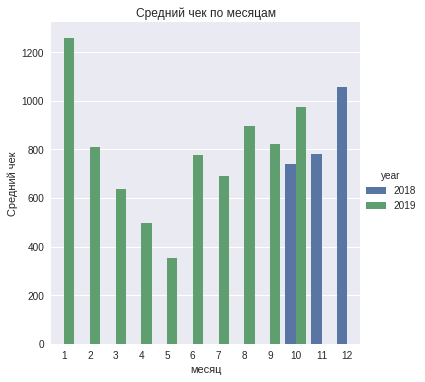

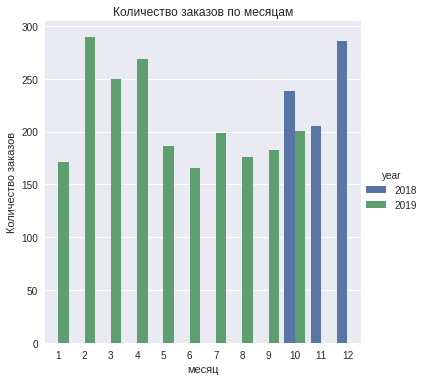

In [ ]:
plt.style.use('seaborn')
for column in revenue.columns[2:]:
    name = {'total_revenue': 'Выручка', 'amount_orders': 'Количество заказов', 'purchase_mean': 'Средний чек'}
    sns.catplot(x='month', y=column, hue='year', kind='bar', data=revenue)
    plt.title(name[column] + ' по месяцам')
    plt.xlabel('месяц')
    plt.ylabel(name[column])
    plt.show()

Июнь 2019 явно выделяется большой выручкой. Количество уникальных заказов даже меньше, чем в остальные месяцы. Значит большие заказы сделали особые клиенты. В другие месяцы такого не наблюдается.

In [ ]:
data.query('year == 2019 and month == 6').groupby('customer_id')['sum_total'].sum().sort_values(ascending=False).head(10)

customer_id
312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6   675,000.00
1d6c8c1f-a799-4418-9af2-1ded47d7a85c   111,690.00
146cd9bf-a95c-4afb-915b-5f6684b17444    49,432.00
db77c238-3c80-4032-9e3c-c30a43f4a650    20,280.00
940c175f-ea87-44e0-9e16-0a3d0a9abecd    20,232.00
09bcc3d0-8134-4f00-8ea5-b74b55d766ad    16,647.00
ae6940d3-a1c7-4997-8853-a5b8afc60d51    10,794.00
57cc80a2-2610-4eef-9457-e7c3bf0c72f0     9,783.00
6cc2b353-7824-4f48-b0a5-c44f6e2a4fb7     8,080.00
f2b76506-06da-46b8-950e-81ca072b0ef3     7,356.00
Name: sum_total, dtype: float64

Посчитаем насколько уменьшилась выручка магазина от года к году по октябрю.

In [ ]:
print('Выручка в октябре 2019 уменьшилась на {:.2%} по сравнению с октябрем 2018'.format(1-(revenue.loc[12, 'total_revenue']/revenue.loc[0, 'total_revenue'])))
print('Количество заказов в октябре 2019 уменьшилась на {:.2%} по сравнению с октябрем 2018'.format(1-(revenue.loc[12, 'amount_orders']/revenue.loc[0, 'amount_orders'])))

Выручка в октябре 2019 уменьшилась на 40.43% по сравнению с октябрем 2018
Количество заказов в октябре 2019 уменьшилась на 15.90% по сравнению с октябрем 2018


По графику можно видеть, что сезонный спрос влияет на выручку. Также отметим, что общая динамика по выручке отрицательная - выручка падает от года к году. Построим диаграммы размаха по цене товара и посмотрим на выбросы. 

Посмотрим разброс цены и количество товара в заказах.

In [ ]:
data[['quantity', 'price']].describe()

,quantity,price
count,"6,737.00","6,737.00"
mean,2.50,462.03
std,15.27,871.30
min,1.00,9.00
25%,1.00,101.00
50%,1.00,135.00
75%,1.00,398.00
max,"1,000.00","14,917.00"


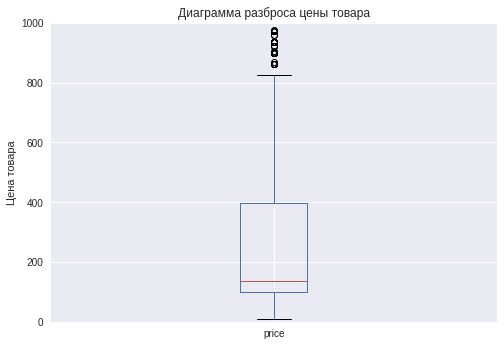

In [ ]:
data.boxplot('price')
plt.ylim(0,1000)
plt.title('Диаграмма разброса цены товара')
plt.ylabel('Цена товара')
plt.show()

Видим, что 50% заказов с ценой товара в 135. 75% заказов не превышают цену товара в 400. 

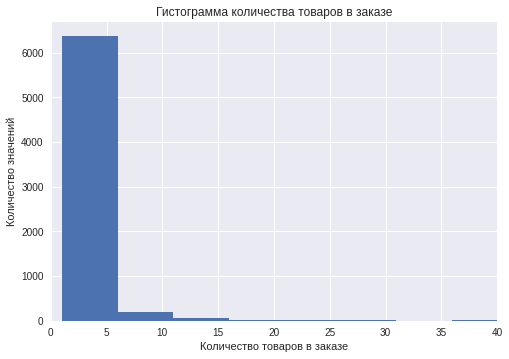

In [ ]:
data['quantity'].hist(bins=200)
plt.xlim(0,40)
plt.title('Гистограмма количества товаров в заказе')
plt.xlabel('Количество товаров в заказе')
plt.ylabel('Количество значений')
plt.show()

По гистограмме видим, что товаров больше 10 в заказе очень мало. Отбросим 2% значений. 

In [ ]:
filter_quantity = data['quantity'].quantile(.98)
filter_quantity

15.0

Посмотрим на другие аномалии и далее отфильтруем исходные данные от аномальных значений, которые могут исказить результы по сегментации клиентов.

Так как задача состоит в сегментации клиентов, то для нас важно получить однородные данные по клиентам - без явных аномалий с большим количеством заказов у клиента. Посмотрим на количество уникальных клиентов. Далее сгруппируем данные по клиентам и оценим количество уникальных заказов на клиента. 

Количество уникальных клиентов.

In [ ]:
data['customer_id'].nunique()

2451

Количество уникальных заказов.

In [ ]:
data['order_id'].nunique()

2784

Оценим сколько заказов приходится на одного клиента.

In [ ]:
data.groupby('customer_id')['order_id'].nunique().describe()

count   2,451.00
mean        1.15
std         2.66
min         1.00
25%         1.00
50%         1.00
75%         1.00
max       126.00
Name: order_id, dtype: float64

Большая часть клиентов сделали заказ 1 раз. Однако есть с количеством заказов 126.

In [ ]:
data.groupby('customer_id')['order_id'].nunique().sort_values(ascending=False).head(10)

customer_id
c971fb21-d54c-4134-938f-16b62ee86d3b    126
4d93d3f6-8b24-403b-a74b-f5173e40d7db     35
73d1cd35-5e5f-4629-8cf2-3fda829d4e58     17
b7b865ab-0735-407f-8d0c-31f74d2806cc      7
0184f535-b60a-4914-a982-231e3f615206      5
bea7a833-2074-42db-bc49-4457abd3c930      4
e0535076-6270-4df2-8621-cb06264a94fa      4
498f12a4-6a62-4725-8516-cf5dc9ab8a3a      4
7d0641a6-e043-487d-b356-38895fe7df84      3
f163e581-59ba-4022-99db-e0973c7497c0      3
Name: order_id, dtype: int64

Первые 3 клиента на троих сделали 178 заказов - явные выбросы.

In [ ]:
filter_count_order = data.groupby('customer_id')['order_id'].nunique().sort_values(ascending=False).head(3)

Сгруппируем данные по заказам и посмотрим на распределение количества уникальных клиентов на 1 заказ. На 1 заказ должен приходиться 1 клиент, если на 1 заказ приходится несколько клиентов, то это ошибка в данных.

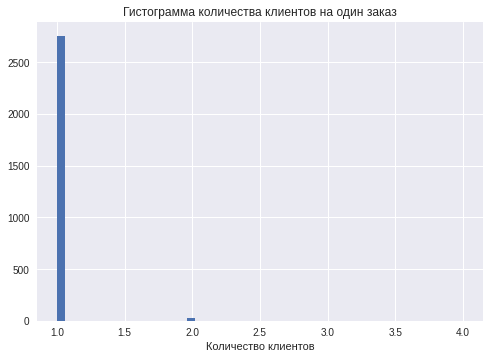

In [ ]:
data.groupby('order_id')['customer_id'].nunique().hist(bins=50)
plt.title('Гистограмма количества клиентов на один заказ')
plt.xlabel('Количество клиентов')
plt.show()

Видим, что есть заказы, с 2-мя уникальными id клиентов. Выделим эти заказы для того, что убрать из исходных данных.

In [ ]:
orders_customers = data.groupby('order_id', as_index=True)['customer_id'].nunique().sort_values(ascending=False)
filter_orders = orders_customers[orders_customers > 1]

Теперь отфильтруем наш исходный датасет от выявленных аномалий. Напомним, что это количество товара в заказе больше 15 штук, клиенты, сделавшие более 17 заказов и заказы в которых обнаружили больше 1-го уникального id клиента.

In [ ]:
data_v1 = data.query('quantity < @filter_quantity and customer_id not in @filter_count_order.index and order_id not in @filter_orders.index').reset_index(drop=True)
data_v1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6308 entries, 0 to 6307
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         6308 non-null   datetime64[ns]
 1   customer_id  6308 non-null   object        
 2   order_id     6308 non-null   int64         
 3   product      6308 non-null   object        
 4   quantity     6308 non-null   int64         
 5   price        6308 non-null   float64       
 6   year         6308 non-null   int64         
 7   month        6308 non-null   int64         
 8   week_day     6308 non-null   int64         
 9   day          6308 non-null   datetime64[ns]
 10  hour         6308 non-null   int64         
 11  sum_total    6308 non-null   float64       
dtypes: datetime64[ns](2), float64(2), int64(6), object(2)
memory usage: 591.5+ KB


* Выбросы и аномалии убрали из данных. Напомним нашу цель: нам нужно разделить клиентов по профилю потребления. Профиль потребления - это характеристика клиента, которая отражает его предпочтения в товарах определенной категории. Так как в наших исходных данных нету разметки по категориям товаров нам необходимо выделить категории из названия товаров в заказах.

Посмотрим на количество уникальных названий товаров

In [ ]:
data_v1['product'].nunique()

2193

Выведем на экран топ-10 самых популярных товаров.

In [ ]:
data_v1['product'].value_counts().sort_values(ascending=False).head(10)

рассада кабачка сорт зебра кассета 6 шт e6                              79
рассада кабачка сорт золотинка кассета 6 шт e6                          78
рассада кабачка сорт белогор кассета 6 шт e6                            77
тагетис крупноцветковый рассада однолетних цветов в кассете по 10 шт    76
рассада огурец фараон ячейки по 6 шт е6                                 76
рассада огурца сорт каролина кассета 6 шт e6                            76
рассада кабачка сорт горный, кассета по 6шт                             76
рассада кабачка сорт аэронавт, кассета по 6шт                           76
рассада патиссона сорт нло белый, кассета по 6шт                        75
рассада кабачка сорт сосновский, кассета по 6шт                         75
Name: product, dtype: int64

In [ ]:
data_v1['product'].tail()

6303                                   литопс микс d-5 см
6304                              мимоза стыдливая d-9 см
6305           сумка-тележка 2-х колесная gimi argo синяя
6306    герань домашняя (пеларгония зональная) цветуща...
6307           сумка-тележка 2-х колесная gimi argo синяя
Name: product, dtype: object

Как можно заметить первые 2 слова в названии товара отражают его принадлежность к тому или иному классу товаров. Например, рассада кабачка, герань домшняя, комнатное растение и т.д.

Выделим первые 2 слова в отдельный столбец

In [ ]:
name_category = data_v1['product'].str.split(n=2, expand=True)
name_category['name'] = name_category[0] + ' ' + name_category[1]
name_category['full_name'] = data_v1['product']

Теперь посмотрим на самые популярные названия товаров и выделим слова-маркеры для категорий. Если по первому слову не понятно к какой категории отнести товара используем столбец 'name' с 2-мя словами. Создадим списки категорий.

In [ ]:
name_category[0].value_counts().sort_values(ascending=False).head(10)

рассада          1372
пеларгония        784
сумка-тележка     303
сушилка           267
муляж             173
томата            162
петуния           160
гладильная        134
коврик            105
герань            103
Name: 0, dtype: int64

Создадим список с наименованиями по убыванию количества повторений. И далее в ручную сформируем список категорий.

In [ ]:
lst_name = name_category[0].value_counts().sort_values(ascending=False).index.tolist()

In [ ]:
# сад
garden = ['пеларгония', 'петуния', 'герань', 'рассада', 'томата', 'герань', 'калибрахоа', 
          'бакопа', 'тагетис', 'однолетнее', 'роза', 'искусственный', 'вербена', 'подвесное', 
          'базилик', 'дыня', 'лобелия', 'цветок', 'эвкалипт', 'мята', 'декабрист', 'фуксия', 
          'арбуз', 'флокс', 'искусственная', 'цикламен', 'фиалка', 'циперус', 'примула', 'новогоднее', 
          'комнатное', 'колокольчик', 'газания', 'капуста', 'бегония', 'пуансеттия', 'виола', 'тимьян', 
          'многолетнее', 'антуриум', 'вербейник', 'камнеломка', 'огурец', 'клубника', 'бальзамин', 
          'алиссум', 'патиссон', 'львиный', 'хлорофитум', 'портулак', 'калла', 'космея', 'лавр', 
          'овсянница', 'кофе', 'эхеверия', 'лаванда', 'барвинок', 'томат', 'мирт', 'хризантема', 
          'фаленопсис', 'табак', 'седум', 'подарочный', 'петрушка', 'нивянник', 'ясколка', 'лапчатка', 
          'гвоздика', 'спатифиллум', 'мимоза', 'котовник', 'аптения', 'цинния', 'азалия', 
          'мединилла', 'сельдерей', 'чабер', 'розмарин', 'настурция', 'астра', 'тыква', 'калатея', 
          'алоэ', 'баклажан', 'кореопсис', 'аквилегия', 'каланхое', 'цинерания', 'цветущее', 'сальвия', 
          'целозия', 'цикламен,', 'ранункулус', 
          'аргирантерум', 'календула', 'лен', 'папоротник', 'вигна', 'кориандр', 'вероника', 
          'салат', 'эхинацея', 'цинерария', 'укроп', 'бадан', 'осина', 'гипсофила', 'девичий', 
          'гиностемма', 'кодонанта', 'маттиола', 'бархатцы', 'годеция', 'ель', 'платикодон', 
          'бузульник', 'физостегия', 'кипарисовик', 'простынь', 'солидаго', 'морковь', 
          'рудбекия', 'лилейник', 'валериана', 'лук', 'эшшольция', 'горох', 'незабудка', 
          'смолевка', 'лаватера', 'шалфей', 'клен', 'агератум', 'колеус', 'агератум', 'циния']
# хранение
storage = ['сумка-тележка', 'тележка', 'чехол', 'вешалка', 'набор вешалок', 'корзина', 'полки', 
           'сумка', 'контейнер', 'кофр', 'коробка', 'этажерка', 'плечики', 
           'ящик', 'комод', 'вешалка-плечики', 'крючок', 'подставка', 'стеллаж', 'вешалка-стойка', 
           'вешалки', 'наматрицник-чехол', 'полка', 'короб', 'ключница', 'вешалка-сушилка', 
           'корзинка', 'вакуумный', 'вешалка-перекладина', 'обувница-3']
# декор
decor = ['коврик', 'муляж', 'штора', 'набор ковров', 'карниз', 'плед', 'декоративная', 
         'ковер', 'покрывало', 'наматрасник', 'ковёр', 'подушка', 'простыня', 'одеяло', 
         'фоторамка', 'двуспальное', 'кольца', 
          'наматрацник', 'пододеяльник']
# кухня
kitchen = ['тарелка', 'набор кружек', 'набор фужеров', 'набор эмалированных', 'набор фужеров', 
           'набор кухонных', 'набор бокалов', 'набор столовых', 'набор стаканов', 
           'набор махровых', 'набор ножей', 'набор посуды', 'скатерть', 'салатник', 'банка', 
           'кружка', 'чайник', 'нож', 'сковорода', 'салфетка', 'термокружка', 'кувшин', 
           'ложка', 'вилка', 'чайный', 'блюдо', 'стакан', 'терка', 'термос', 'блюдце', 
           'измельчитель', 'хлебница', 'емкость', 'стеклянная', 'лоток', 
           'форма', 'скалка', 'миска', 'кухонное', 'чайная', 'овощеварка', 'вкладыши', 
           'кастрюля', 'tepмокружка', 'разделочная', 'бидон', 'соковарка', 'тортница', 'шприц', 
           'лопатка', 'просеиватель', 'сахарница', 'антинакипин', 'столовый', 'миксер', 
           'термостакан', 
             'крышка', 'мини-сковорода', 'электроштопор', 'толкушка', 'фарфоровая', 
             'картофелемялка', 'соковыжималка', 'сервировочная', 'орехоколка', 'рыбочистка', 
             'бульонница', 'противень', 'столовая', 'набор форм', 'сито', 'сотейник', 'венчик']
# Ванная
bathroom = ['полотенце', 'махровое', 'мыло', 'сиденье', 'штанга', 'зубная', 'дозатор', 
            'паста зубная', 'подголовник', 'халат', 'ванна', 'махровый']
# хозяйственные товары
household = ['сушилка', 'гладильная', 'таз', 'набор vileda', 'щетка', 'швабра', 'ведро', 
             'подрукавник', 'перчатки', 'корыто', 'ёрш', 'окномойка', 'комплект', 'насадка', 
             'доска', 'настенная', 'рукав', 'средство', 
             'щетка-сметка', 'урна', 'веревка', 'вантуз', 'шило', 'совок', 'ткань', 'веник', 
             'мусорный', 'скребок', 'шпагат', 'насадка-моп', 
         'тряпкодержатель', 'сетка', 'кондиционер', 'мешок', 'бельевые', 'решетка', 
         'ополаскиватель', 'гипоаллергенный', 'сменная', 'отжим', 'губка', 
        'стиральный', 'универсальное', 'сметка', 'ерш', 'тряпка', 'прищепки', 
             'чистящий', 'отбеливатель', 'тряпка', 'щётка', 'антижир']
# инструменты
tools = ['стремянка', 'набор сверел', 'набор прецизионных', 'набор инструментов', 'термометр', 
         'лестница-стремянка', 'стремянки', 'холодная', 'петля-стрела', 
         'стяжка', 'стремянка-табурет', 'измерительный', 'сверло-фреза,', 'лестница', 'мерный']
# техника
technique = ['утюг', 'котел', 'автоматическая', 'мантоварка-пароварка', 'фен', 'весы', 'пылесос']

In [ ]:
name_category['cat'] = 'другое'
def categoryzation(column, category, name_cat):
    for i in category:
        for ix, vl in name_category[column].items():
            if vl == i:
                name_category.loc[ix, 'cat'] = name_cat

In [ ]:
categoryzation(0, garden, 'Сад')

In [ ]:
categoryzation(0, storage, 'Хранение')
categoryzation('name', storage, 'Хранение')

In [ ]:
categoryzation(0, decor, 'Декор')
categoryzation('name', decor, 'Декор')

In [ ]:
categoryzation(0, kitchen, 'Кухня')
categoryzation('name', kitchen, 'Кухня')

In [ ]:
categoryzation(0, bathroom, 'Ванная')
categoryzation('name', bathroom, 'Ванная')

In [ ]:
categoryzation(0, household, 'Хозтовары')
categoryzation('name', household, 'Хозтовары')

In [ ]:
categoryzation(0, tools, 'Инструменты')
categoryzation('name', tools, 'Инструменты')

In [ ]:
categoryzation(0, technique, 'Техника')
categoryzation('name', technique, 'Техника')

Проверяем работу функции.

In [ ]:
name_category[name_category[0] == 'стремянка-табурет']

,0,1,2,name,full_name,cat
1087,стремянка-табурет,алюминиевая,hailo l90 step-ke 4442-701 2х2 ступени,стремянка-табурет алюминиевая,стремянка-табурет алюминиевая hailo l90 step-k...,Инструменты
1320,стремянка-табурет,алюминиевая,hailo l90 step-ke 4442-701 2х2 ступени,стремянка-табурет алюминиевая,стремянка-табурет алюминиевая hailo l90 step-k...,Инструменты
1322,стремянка-табурет,алюминиевая,hailo l90 step-ke 4442-701 2х2 ступени,стремянка-табурет алюминиевая,стремянка-табурет алюминиевая hailo l90 step-k...,Инструменты


Посмотрим сколько осталось.

In [ ]:
name_category.query('cat == "другое"').count()

0            174
1            174
2            174
name         174
full_name    174
cat          174
dtype: int64

Попробуем использовать столбец с атрибутами товара. Например, обратил внимание, что почти у всех растений в атрибутах указывается диаметр. Посмотрим на список.

In [ ]:
garden_list = name_category[name_category['full_name'].str.contains("d-")].query('cat == "другое"')[0].to_list()

In [ ]:
garden_list

['радермахера',
 'хризолидокарпус',
 'шеффлера',
 'юкка',
 'суккулент',
 'адиантум',
 'кампанула',
 'нолина',
 'глоксиния',
 'гортензия',
 'аспарагус',
 'молодило',
 'гербера',
 'душица',
 'мелисса',
 'альбука',
 'крассула',
 'артемизия',
 'дендробиум',
 'калоцефалус',
 'каллуна',
 'капсикум',
 'соланум',
 'диффенбахия',
 'подсолнечник',
 'пуансетия',
 'крассула',
 'аспарагус',
 'фиттония',
 'шеффлера',
 'фикус',
 'гербера',
 'гимнокалициум',
 'крокусы',
 'гиацинт',
 'афеляндра',
 'цитрофортунелла',
 'пеперомия',
 'синнингия',
 'гардения',
 'земляника',
 'дендробиум',
 'мускари',
 'мускари',
 'земляника',
 'муррайя',
 'джункус',
 'драцена',
 'фатсия',
 'молодило',
 'сциндапсус',
 'пряные',
 'гардения',
 'фатсия',
 'лантана',
 'буддлея',
 'монарда',
 'кабачок',
 'кабачок',
 'кабачок',
 'хамедорея',
 'гардения',
 'лантана',
 'зверобой',
 'импатиенс',
 'замиокулькас',
 'амариллис',
 'диффенбахия',
 'зверобой',
 'пахира',
 'эхинокактус',
 'зверобой',
 'душица',
 'литопс']

Добавим в категорию Сад

In [ ]:
categoryzation(0, garden_list, 'Сад')

Посмотрим на ассортимент интернет магазина по категориям. Вычислим количество уникальных наименований в заказах клиентов и сгруппируем их количество относительно категории. 

In [ ]:
stock = name_category.groupby('cat')['full_name'].nunique().sort_values(ascending=False).reset_index().rename(columns={'full_name': 'amount_unique_goods'})
stock['share_cat, %'] = stock['amount_unique_goods'] / stock['amount_unique_goods'].sum() * 100
stock

,cat,amount_unique_goods,"share_cat, %"
0,Сад,948,43.23
1,Хозтовары,326,14.87
2,Хранение,272,12.40
3,Кухня,266,12.13
4,Декор,225,10.26
5,другое,68,3.10
6,Инструменты,49,2.23
7,Ванная,27,1.23
8,Техника,12,0.55


In [ ]:
stock['amount_unique_goods'].sum()

2193

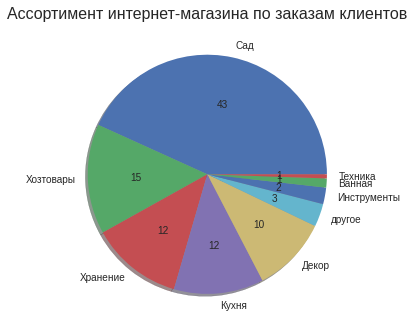

In [ ]:
name_category.groupby('cat')['full_name'].nunique().sort_values(ascending=False)\
.plot(kind='pie', autopct='%.0f', shadow=True)
plt.xticks(rotation=45)
plt.title('Ассортимент интернет-магазина по заказам клиентов', fontsize=16)
plt.ylabel('')
plt.show()

Категория Сад лидирует по количеству уникальных наименований товаров. Категории меньше 10 %: инструменты, Ваннная, техника требуют расширения ассортимента.

* Агрегируем данные относительно категорий и посмотрим: количество клиентов, количество заказов, средний чек в категориях. Посмотрим также какая категория приности наибольшую прибыль.

In [ ]:
data_v1 = data_v1.join(name_category['cat'])

In [ ]:
data_v1.rename(columns={'cat': 'category'}, inplace=True)

In [ ]:
data_category = data_v1.groupby('category')\
.agg(unique_customers=('customer_id', 'nunique'), unique_orders=('order_id', 'nunique'), mean_price=('price', 'mean'), revenue=('sum_total', 'sum'))

In [ ]:
data_category.sort_values('revenue', ascending=False)

,unique_customers,unique_orders,mean_price,revenue
category,,,,
Хранение,498,520,"1,362.01","984,416.00"
Хозтовары,498,521,"1,061.05","798,099.00"
Сад,707,788,140.46,"702,683.00"
Декор,254,271,601.11,"322,963.00"
Кухня,258,266,446.59,"267,181.00"
Инструменты,55,58,"1,471.42","164,441.00"
другое,75,75,437.54,"55,824.00"
Ванная,35,37,624.14,"33,953.00"
Техника,12,13,"2,073.15","26,951.00"


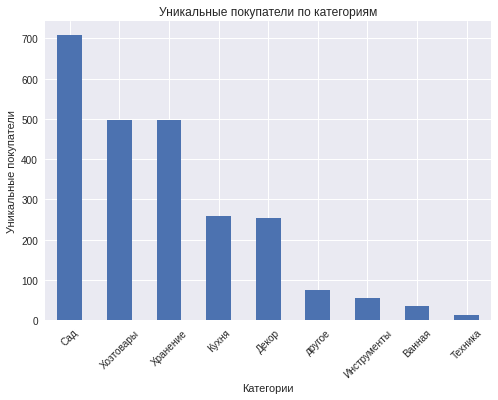

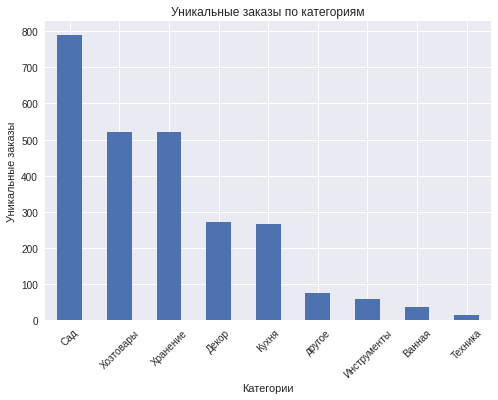

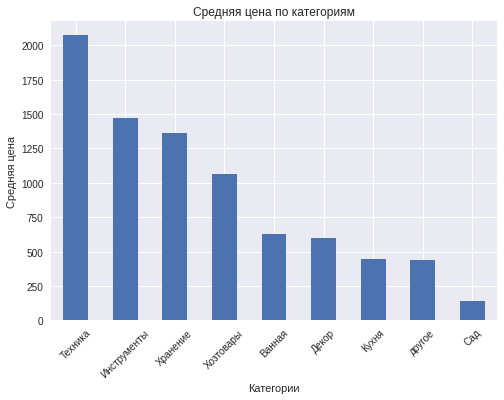

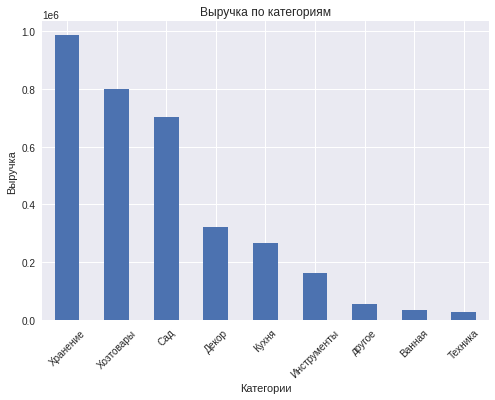

In [ ]:
for column in data_category.columns:
    name = {'unique_customers': 'Уникальные покупатели', 'unique_orders': 'Уникальные заказы', 'mean_price': 'Средняя цена', 'revenue': 'Выручка'}
    data_category[column].sort_values(ascending=False).plot(kind='bar')
    plt.xticks(rotation=45)
    plt.title(name[column] + ' по категориям')
    plt.xlabel('Категории')
    plt.ylabel(name[column])
    plt.show()

Топ-3 категории по выручке: **хранение, Хозтовары и сад**. Категория "хранение" заняла первое место, т.к достаточно высокий средний чек при достаточном количестве клиентов. Категория "Сад" генерирует самое большое количество заказов и клиентов, однако при самом низком среднем чеке не позволяет выйти на первое место по выручке. При всех издержках работы интернет-магазина необходимо зарабатывать на каждом заказе, поэтому важно стимулировать клиентов увеличивать средний чек - хорошая механика сопутствующие товары. Например, категории Хранение и Сад хорошо пересекаются в использовании. Посмотрим какие категории сочетают покупатели.

In [ ]:
customer_category = data_v1.groupby('customer_id')['category'].nunique().sort_values(ascending=False)
customer_list = customer_category[customer_category > 1].index.to_list()

In [ ]:
data_v1.query('customer_id in @customer_list').pivot_table(index=['customer_id', 'category', 'product'], values ='order_id', aggfunc='count').head(50)

order_id
customer_id                          category    product                                                     
0982f6b9-328f-4a67-b7ee-cd0a114868f0 Инструменты стремянка металлическая 3 ступени, см3, ника               1
                                     Хранение    контейнер для свч полимербыт премиум 1,2 л 4356200         2
0a4e4711-5cb7-4bae-93cf-6731902708de Сад         комнатное растение в горшке алое вера, d12, h30            1
                                     Хозтовары   гладильная доска eurogold europa paris 120х38 с...         1
                                                 гладильная доска ника бест 122х40 см нб                    1
0b72ee63-d869-4ecf-b437-e198cd1a6593 Хозтовары   подрукавник gimi planet для гладильной доски               1
                                     Хранение    чехол для гладильной доски i love gimi l из пол...         1
13f31376-e99b-4a4a-a538-8a5dc64f6599 Декор       муляж морковь 16 см                                        1
                                                 штора для ванной и душа текстильная, 180х200см....         1
                                     Хранение    вешалка настенная ника вн3 3 крючка медный антик           1
                                                 вешалка самоклеющая на 4 крючка 1110008                    1
14a04483-6576-4f35-b197-d24c3a8c9ae0 Инструменты стремянка бытовая zalger 111-5 алюминиевая 5 ст...         1
                                     Хозтовары   средство для мытья пола ecomatic green cleaner ...         1
                                     другое      ароматизированное средство дудаления известково...         1
                                                 бальзам для мытья посуды mama ultimate ecosoda ...         1
17213b88-1514-47a4-b8aa-ce51378ab34e Кухня       мини-сковорода marmiton "сердце" с антипригарны...         2
                                                 сковорода алюминиевая с антипригарным покрытием...         2
                                                 стеклянная крышка для сковороды alpenkok 26 см ...         2
                                     Хозтовары   сушилка для белья напольная colombo star 18, 3679          2
197e747c-e8c6-4874-af3c-a7d857b82afb Декор       коврик хлопковый 45х75 см цвета в ассортименте ...         1
                                     Хозтовары   сушилка для белья напольная ника сбп1/с 18 м               1
1ea6fce0-e942-465b-ba20-9c4df6b8681e Хранение    чехол для гладильной доски zalger 520138 140х50...         1
                                                 чехол для гладильной доски с дизайном venezia 1...         1
                                     другое      подкладка под чехол zalger 520114 135х50 см войлок         1
                                                 подкладка под чехол zalger 520140 135х50 см пор...         1
227e2c2c-8f44-4345-8d08-b135da7e9704 Ванная      махровое полотенце 50х30 см wellness *амели_1-3...         1
                                     Кухня       набор стаканов ежевика 3 шт 300 мл дсг424020311            1
278cffb9-4414-449a-8cb8-ffdbef1bf1d8 Кухня       ложка обувная металлическая крашенная 220, 1205155         1
                                     Хозтовары   перчатки резиновые универсальные centi, р-р m, ...         1
                                                 таз пластмассовый 4,5 л пищевой "космея" (ангор...         1
                                     Хранение    плечики пластмассовые размер 48 - 54 мп 1205160            1
                                     другое      ролик для чистки одежды *clear line* (20 слоев)...         1
                                                 сменный блок для ролика 2 шт (r160071), rozenba...         1
2a1d60f3-cdc4-49db-8f2b-919bb8098411 Сад         герань домашняя (пеларгония зональная) цветущая...         1
                                                 герань домашняя (пеларгония зональная) цветущая...         1
                               

Категории Хранение и хозтовары отлично подходят для сопутствующих товаров или последующих заказов в других категориях. Это можно использовать для формирования персональных предложений на основе истории покупки.

In [ ]:
data_v1.head()

,date,customer_id,order_id,product,quantity,price,year,month,week_day,day,hour,sum_total,category
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.00,2018,10,0,2018-10-01,0,142.00,Сад
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12,...",1,194.00,2018,10,0,2018-10-01,0,194.00,Сад
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112.00,2018,10,0,2018-10-01,0,112.00,Сад
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс d-9 см,1,179.00,2018,10,0,2018-10-01,0,179.00,Сад
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула d-12 см h-25 см,1,112.00,2018,10,0,2018-10-01,0,112.00,Сад


* Посомтрим на самые продаваемые товары в категориях. Эту информацию также можно использовать для персонального предложения клиентам. 

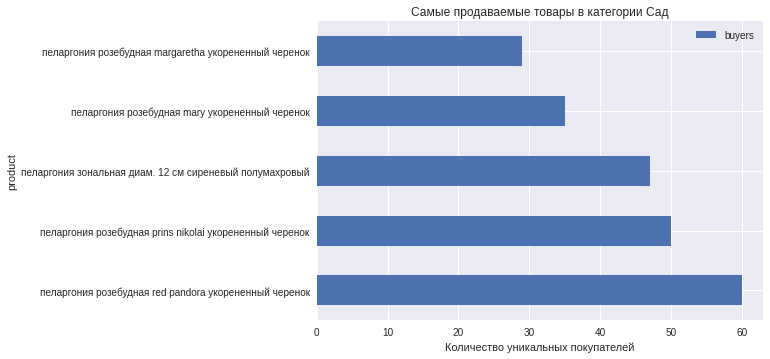

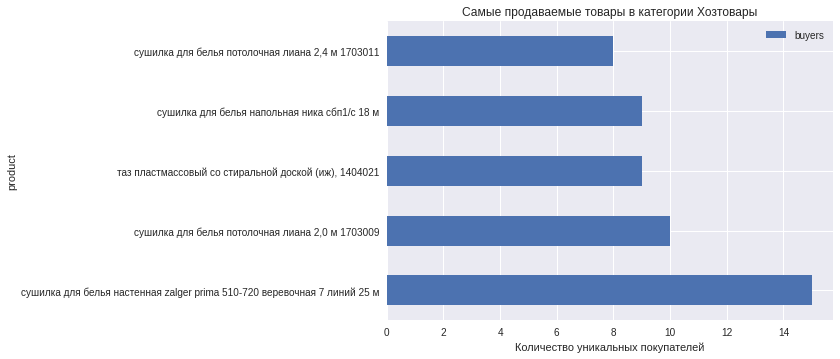

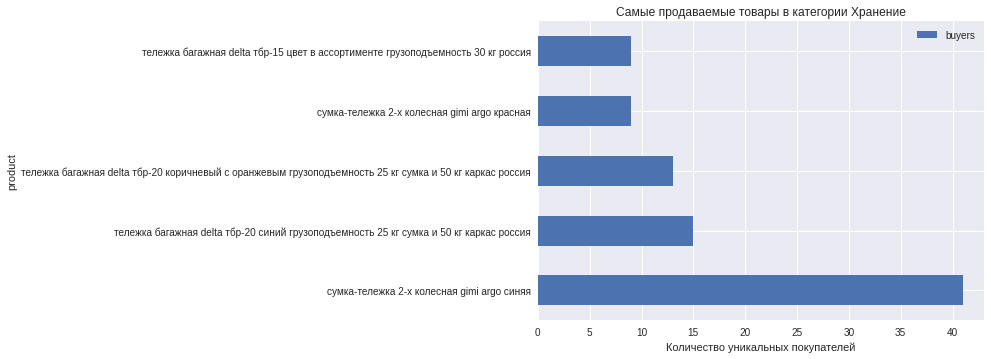

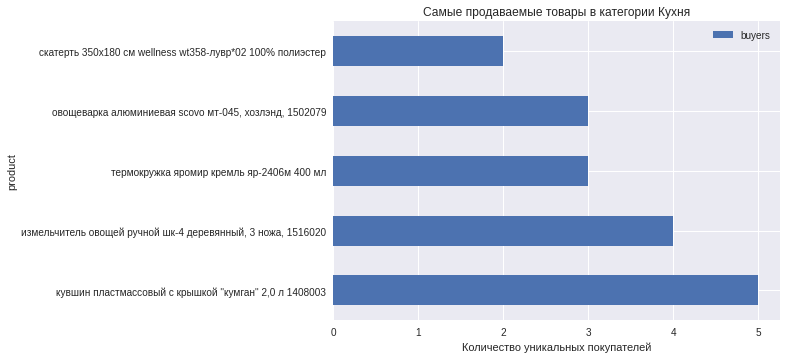

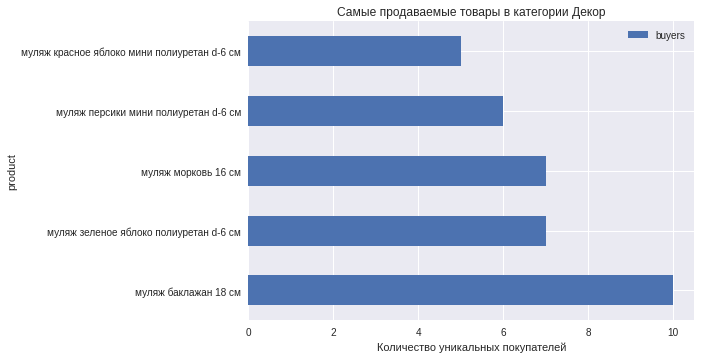

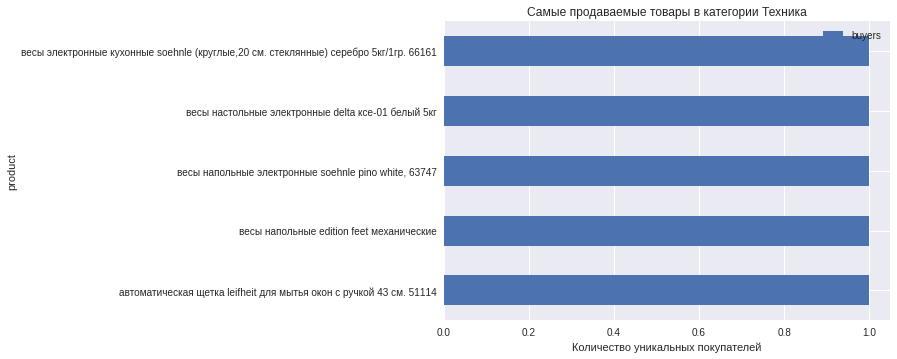

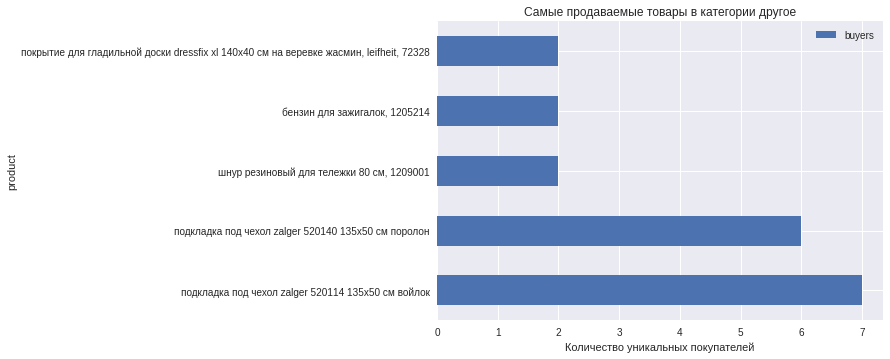

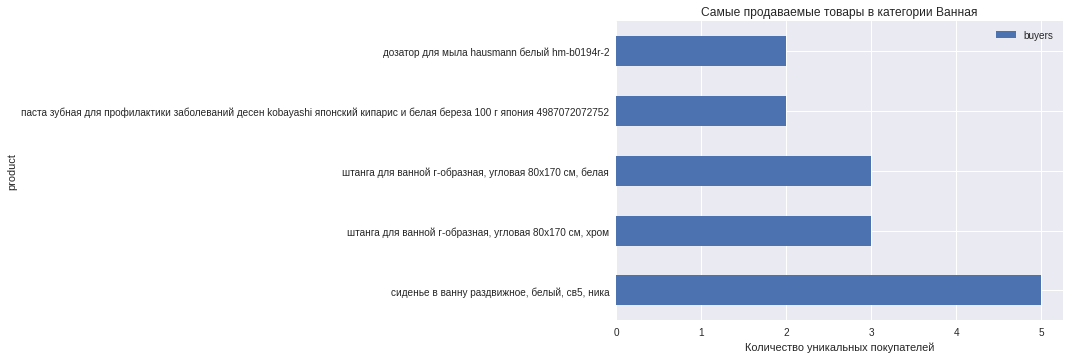

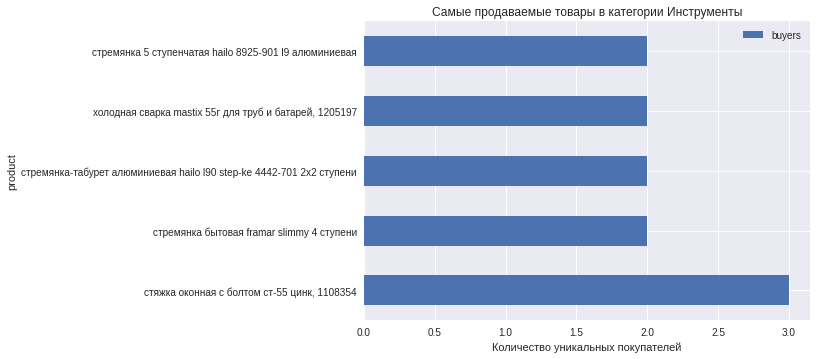

In [ ]:
for cat in data_v1['category'].unique():
    data_v1.query('category == @cat').groupby('product').agg(buyers =('customer_id', 'nunique')).sort_values('buyers', ascending=False).head(5).plot(kind='barh')
    plt.title('Самые продаваемые товары в категории ' + cat)
    plt.xlabel('Количество уникальных покупателей')
    plt.show()

Исходя из этой информации можно устраивать промоакции для категорий. Для увеличения посетителей категории. Эти товары с большей вероятностью привлекут внимание. 

* Теперь посмотрим как меняется спрос в зависимости от сезона: зима, весна, лето, осень.

In [ ]:
data_v1['month'].unique()

array([10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9])

In [ ]:
def season(x):
    if x >= 3 and x <=5:
        return 'весна'
    if x >= 6 and x <=8:
        return 'лето'
    if x >= 9 and x <=11:
        return 'осень'
    return 'зима'

In [ ]:
data_v1['season'] = data_v1['month'].map(season)

In [ ]:
data_v1.sample(5)

,date,customer_id,order_id,product,quantity,price,year,month,week_day,day,hour,sum_total,category,season
6232,2019-10-18 14:00:00,05c8c33d-37de-4ea6-b6c0-97d7622d0f7e,73025,"коврик придверный, полипропилен, 40х70 см, kok...",1,749.00,2019,10,4,2019-10-18,14,749.00,Декор,осень
5446,2019-07-10 19:00:00,1441d772-6f55-490f-8edf-171bef655b16,14896,рассада зелени для кухни тимьян-чабрец розовый...,1,89.00,2019,7,2,2019-07-10,19,89.00,Сад,лето
285,2018-10-22 09:00:00,0a8362cf-e2d8-4ffc-8072-33239f5e450a,68715,"комнатное растение в горшке аспарагус мейера, ...",1,224.00,2018,10,0,2018-10-22,9,224.00,Сад,осень
5030,2019-06-16 12:00:00,f2b76506-06da-46b8-950e-81ca072b0ef3,14863,нивянник (ромашка) крупноцветковый белый объем...,3,105.00,2019,6,6,2019-06-16,12,315.00,Сад,лето
6105,2019-10-03 13:00:00,7abce1cc-bc8c-4362-b61a-0cbb4822ed29,72844,сумка-тележка хозяйственная rolser jet joy син...,1,"3,975.00",2019,10,3,2019-10-03,13,"3,975.00",Хранение,осень


Агрегируем относительно сезона и посмотрим на выручку, количество заказов и популярность категории.

In [ ]:
season_data = data_v1.groupby(['season', 'category']).agg(revenue=('sum_total', 'sum'), amount_orders=('order_id', 'nunique')).reset_index()
season_data

,season,category,revenue,amount_orders
0,весна,Ванная,"5,145.00",6
1,весна,Декор,"80,883.00",56
2,весна,Инструменты,"38,188.00",9
3,весна,Кухня,"54,351.00",49
4,весна,Сад,"274,773.00",308
5,весна,Техника,"11,674.00",4
6,весна,Хозтовары,"153,438.00",107
7,весна,Хранение,"255,855.00",101
8,весна,другое,"21,080.00",17
9,зима,Ванная,"10,171.00",7


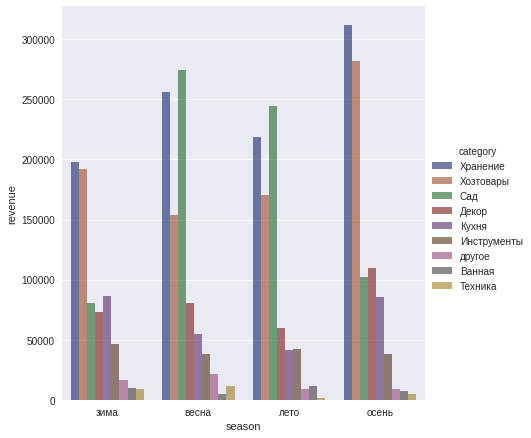

In [ ]:
#plt.figure(figsize=(20, 15))
sns.catplot(data=season_data, kind="bar",
    x="season", y="revenue", hue="category",
    palette="dark", alpha=.6, height=6, order=['зима', 'весна', 'лето', 'осень'], 
    hue_order = season_data.groupby('category')['revenue'].sum().sort_values(ascending=False).index)
plt.show()

Весна-лето сезон для покупки растений. Однако осень-зима сильно снижение выручки для этой категории. Категории хранение и хозтовары менее подвержены сезонности, хотя и явный всплеск спроса наблюдается осенью. 

## Сегментация клиентов

Для начала определим набор признаков из наших данных. Здесь нам необходимо выбрать те данные, которые наиболее сильно отражают профиль потребления пользователя. Есть много способов какие признаки добавить от сезона и времени в которое совершается покупка до выручки и количества товаров, которое купил клиент. Для нас важно добавить в признаки именно данные по продукту в заказе и категории к которой этот продукт принадлежит. Также мы ранее видели, что категории различаются по среднему чеку, количеству наименований, поэтому добавим эти характеристики тоже.

In [ ]:
data_class = data_v1.groupby('customer_id')\
.agg(revenue=('sum_total', 'sum'), amount_orders=('order_id', 'nunique'), 
    amount_products=('product', 'nunique'), avg_price=('price', 'mean'), 
    avg_check=('sum_total', 'mean'),
    max_price=('sum_total', 'max'), quantity=('quantity', 'sum'),
    prefer_category=('category', 'max'))\
.reset_index()

Важно, чтобы в данных не было сильных перекосов (выбросов) и других признаков, которые могут исказить результат. Поэтому уберем из данных клиентов из категории "другое", т.к она небольшая и по ней сложно определить предпочтение клиента к товару. Также посмотрим на клиентов, которые принесли самую большую выручку.

In [ ]:
data_class = data_class.query('prefer_category != "другое"')

In [ ]:
data_class.sort_values('revenue', ascending=False).head()

,customer_id,revenue,amount_orders,amount_products,avg_price,avg_check,max_price,quantity,prefer_category
269,1d6c8c1f-a799-4418-9af2-1ded47d7a85c,"114,750.00",1,12,127.50,129.22,420.00,900,Сад
783,57cc80a2-2610-4eef-9457-e7c3bf0c72f0,"65,220.00",1,1,"1,087.00","1,087.00","1,087.00",60,Хранение
1411,9f1e7d7d-ff10-4eb1-b596-1cbf8075aa3f,"50,770.00",1,21,867.44,"1,015.40","3,074.00",96,Хранение
1534,ae6940d3-a1c7-4997-8853-a5b8afc60d51,"32,382.00",1,1,"1,799.00","2,023.88","3,598.00",18,Хозтовары
658,498f12a4-6a62-4725-8516-cf5dc9ab8a3a,"30,440.00",3,3,979.67,"10,146.67","15,680.00",25,Хозтовары


Посмотрим есть ли выбросы в данных.

Первый клиент заказал 900 ед. товара на общую сумму 114 750. Этот клиент будет искажать результат. Отбросим эти данные.

In [ ]:
data_class = data_class.drop(269)

Преобразуем категориальные данные в числовые.

In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder() # создаём переменную класса LabelEncoder - кодировщик
data_class['int_category'] = encoder.fit_transform(data_class['prefer_category']) # используем кодировщик, чтобы "перевести" строковые названия в числа
#data_class['int_season'] = encoder.fit_transform(data_class['season'])
data_class.head()

,customer_id,revenue,amount_orders,amount_products,avg_price,avg_check,max_price,quantity,prefer_category,int_category
0,000d6849-084e-4d9f-ac03-37174eaf60c4,555.00,1,4,138.75,138.75,150.00,4,Сад,4
1,001cee7f-0b29-4716-b202-0042213ab038,442.00,1,1,442.00,442.00,442.00,1,Хозтовары,6
2,00299f34-5385-4d13-9aea-c80b81658e1b,914.00,1,1,457.00,914.00,914.00,2,Хозтовары,6
3,002d4d3a-4a59-406b-86ec-c3314357e498,"1,649.00",1,1,"1,649.00","1,649.00","1,649.00",1,Хранение,7
4,003bbd39-0000-41ff-b7f9-2ddaec152037,"2,324.00",1,1,"1,162.00","2,324.00","2,324.00",2,Хранение,7


Посмотрим на корреляцию признаков.

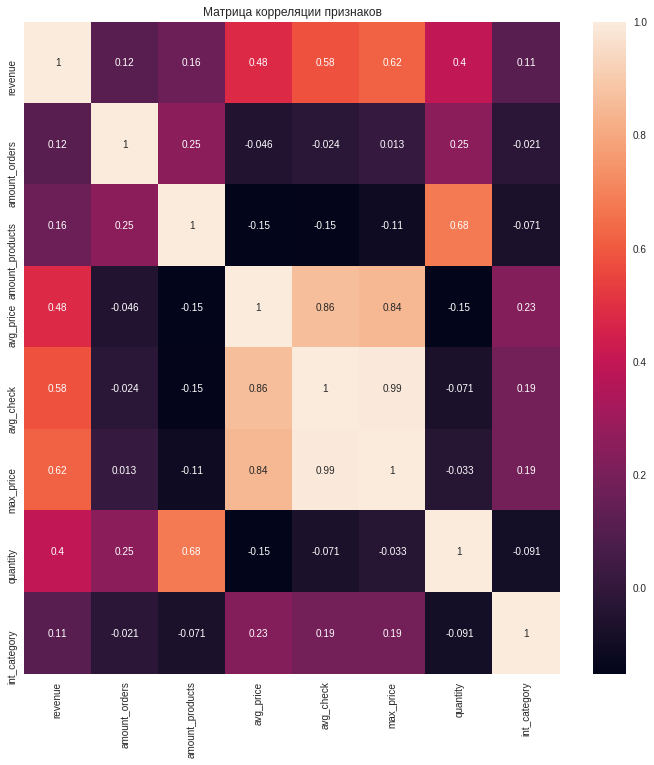

In [ ]:
cm = data_class.corr()
plt.figure(figsize=(12,12))
sns.heatmap(data=cm, annot=True)
plt.title('Матрица корреляции признаков')
plt.show()

Стандартизируем данные.

In [ ]:
X = data_class.drop(['customer_id', 'prefer_category'], axis=1)
scaler = StandardScaler()
x_sc = scaler.fit_transform(X)

Рисуем дендрограмму.

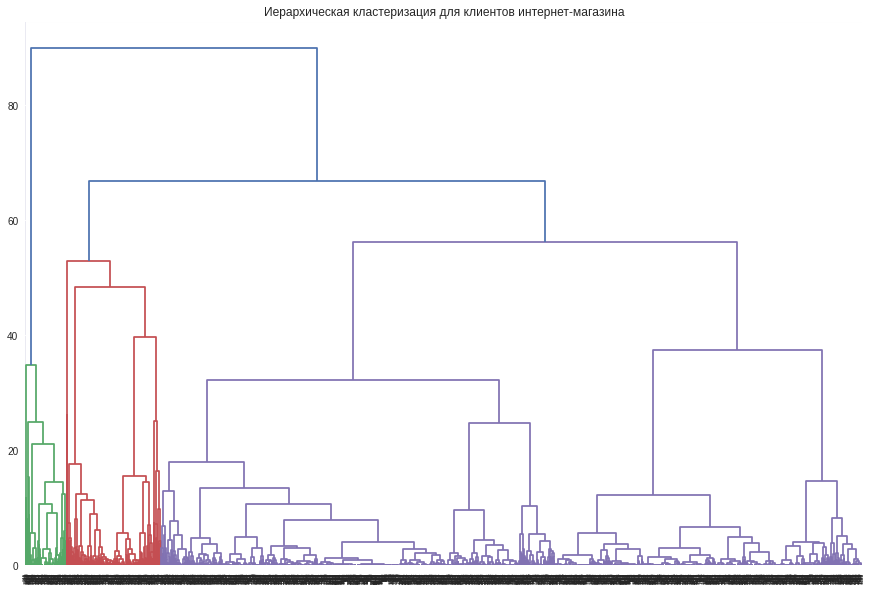

In [ ]:
linked = linkage(x_sc, method = 'ward')
plt.figure(figsize=(15, 10))
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация для клиентов интернет-магазина')
plt.show()

Алгоритм делит на 3 больших кластера (3 цвета). Однако фиолетовый кластер можно разделить еще на 2 кластера. Тогда возьмем для алгоритма K-Means количество кластеров равное 4 и проведем расчеты.

In [ ]:
km = KMeans(n_clusters = 4, random_state=0)
labels = km.fit_predict(x_sc)

In [ ]:
data_class['class'] = labels
data_class.groupby('class').mean().T

class,0,1,2,3
revenue,"1,198.00","4,044.67",729.32,"6,493.33"
amount_orders,1.05,1.75,1.06,1.07
amount_products,1.14,15.92,1.77,1.06
avg_price,872.80,128.27,357.51,"4,012.25"
avg_check,962.37,193.53,470.50,"4,734.98"
max_price,991.72,433.18,492.17,"4,821.79"
quantity,1.77,33.40,3.54,2.51
int_category,6.44,3.88,3.07,5.47


Различия в среднем чеке есть и в некоторых кластерах они существенные. Например, группы 0 и 1 различаются по среднему чеку почти в 5 раз. Также есть различия в количестве товара в корзине, разнообразии приобретаемого ассортимента (amount_products) и среднем количестве заказов. Посмотрим имеют ли эти различия статистическое подтверждение. 

Из-за большого разброса значений и большой дисперсии будем использовать критерий Мана-Уитни для проверки гипотезы о равенстве среднего чека. Для сравнения возьмем близкие по среднему чеку 1-ю и 2-ю группу. Нулевая гипотеза будет о равенстве среднего чека этих групп. Тогда альтернативная гипотеза говорит о неравенстве среднего чека 2-х групп.

In [ ]:
from scipy import stats as st
alpha = .05 # уровень статистической значимости
results = st.mannwhitneyu(data_class[data_class['class'] == 1]['avg_check'], data_class[data_class['class'] == 2]['avg_check'])[1]
print('p-value:', "{0:.30f}".format(results))
if (results < alpha):
    print('Отвергаем нулевую гипотезу. Средний чек 1-го кластера отличается от среднего чека 2-го кластера')
else:
    print('Не получилось отвергнуть нулевую гипотезу. Средний чек 1-го кластера не отличается от среднего чека 2-го кластера')

p-value: 0.000001070551397634782107330599
Отвергаем нулевую гипотезу. Средний чек 1-го кластера отличается от среднего чека 2-го кластера


* Посмотрим количество клиентов в каждом кластере и какими преимущественно категориями характеризуется каждый кластер.

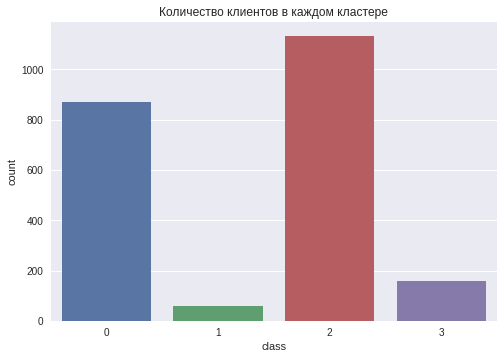

In [ ]:
sns.countplot(x='class', data=data_class)
plt.title('Количество клиентов в каждом кластере')
plt.show()

Основное количество клиентов попало в 0-й и 2-й кластеры. По всей видимости в 1-й и 3-й попали клиенты с сильно выделяющимися признаками. Посмотрим какие категории характерны для каждого кластера.

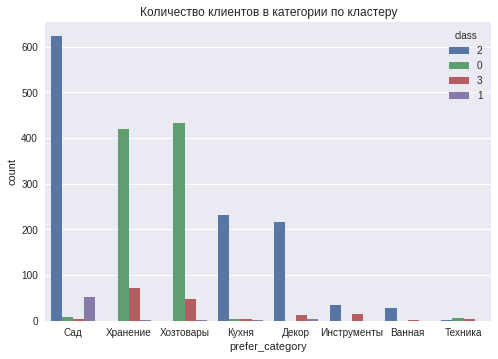

In [ ]:
sns.countplot(x='prefer_category', hue='class', data=data_class, 
              order=data_class.groupby('prefer_category')['customer_id'].count().sort_values(ascending=False).index, 
              hue_order=data_class.groupby('class')['customer_id'].count().sort_values(ascending=False).index)
plt.title('Количество клиентов в категории по кластеру')
plt.show()

Видим, что для 2-го кластера харатерны категории сад, кухня, декор. А для 0-го кластера категории хранение и хозтовары. Это можно использовать при формировании персонального предложения.

Посмотрим какие сегменты приносят наибольшую выручку.

In [ ]:
data_class.groupby('class')['revenue'].sum().sort_values(ascending=False)

class
0   1,042,261.00
3   1,038,933.00
2     826,314.00
1     242,680.00
Name: revenue, dtype: float64

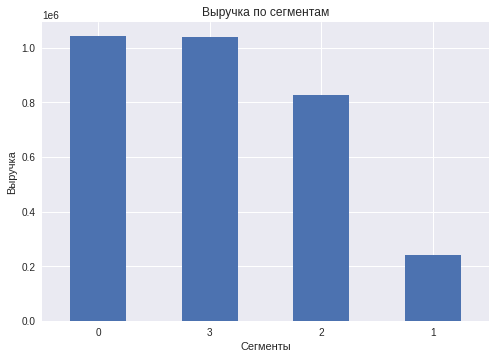

In [ ]:
data_class.groupby('class')['revenue'].sum().sort_values(ascending=False).plot(kind='bar')
plt.xticks(rotation=0)
plt.title('Выручка по сегментам')
plt.xlabel('Сегменты')
plt.ylabel('Выручка')
plt.show()

Сегменты 0 и 3, где основными категориями являются хранение и хозтовары приносят самую большую прибыль. Далее идет сегмент с самым большим количеством клиентов, там основная категория "Сад".

## Выводы

* Тендеция по выручке отрицительная. Выручка в октябре 2019 уменьшилась на 40.43% по сравнению с октябрем 2018. Спрос имеет сезонный характер из-за товарной матрицы: товары для сада одна из основных категорий приносящая выручку  лучше продаются весной-летом, осенью и зимой сильный спад спроса более чем в 2 раза.
* Топ-3 категории по выручке: **хранение, Хозтовары и сад**. Категория "хранение" заняла первое место, т.к достаточно высокий средний чек при достаточном количестве клиентов. Категория "Сад" генерирует самое большое количество заказов и клиентов, однако при самом низком среднем чеке не позволяет выйти на первое место по выручке. Категории Хранение и Хозтовары имеют менее выраженную сезонность и хороший средний чек от 1000 до 1300.
* Сегментация клиентов на основе потребительских признаков выявила 4 основных кластера, которые имеют следующие явные различия: категория товаров, количество товаров в заказе, средний чек. 

## Презентация

https://drive.google.com/file/d/13bl3uBOY4Eikw3WX9Jww-vVA4cGwPXp3/view?usp=sharing

## Дашборд

https://public.tableau.com/views/dashboard_final_project_practicum2/Dashboard1?:language=en-US&:display_count=n&:origin=viz_share_link